<a href="https://colab.research.google.com/github/EmmarieR/CNM-DeepDive-Data-Science-Projects/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project #2: Predicting Housing Prices with Linear Regression Methods

Deep Dive Data-Science Part-Time
___
Emmarie Ryan - March 21st, 2025

## Problem Definition


For this project, we will be predicting housing prices using regression modeling. Specifically, we will be aiming to have the lowest root mean squared percentage error (RMSPE) value. The RMSPE quantifies the average percentage difference between our predicted values versus the actual values. This problem is a supervised learning problem since we will be generating output values based on inputs, and then comparing our outputs to observed outputs.
___

## Data Collection/Sources


###Data Overview###

The Housing data set is available online at [AWS S3](https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Data/Housing.Data.csv)

This data set is a series of houses and their final sale price. The data set includes information across the data columns for each house sold. The information ranges from house location, size, utilities, room types, and much more.


An additional dictionary PDF provides the definitions to the housing terminology that we will see when exploring the data set. The PDF is viewable at [AWS S3](https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Housing%20-%20Data%20Documentation.pdf)

______

###Installs and Imports###

In [1]:
!pip install pdfplumber -q

In [2]:
import pandas as pd
import numpy as np

import pdfplumber
import requests

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import preprocessing



import matplotlib.pyplot as plt
import seaborn as sns

_________________

###Load Data ###

Let's begin by taking a quick look at the provided data set and supplementary document.

In [3]:
def text_pdf(pdf_url, all_pages = False):
  """Given a PDF url, returns the text from the first page as a string by default.
  Setting all_pages = True returns text from all pages as a string of text.
  """

  # call variable for text string
  text_string = ''

  # download the PDF from the URL
  pdf_url = 'https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Housing%20-%20Data%20Documentation.pdf'
  response = requests.get(pdf_url)

  # Save the PDF to 'content' folder in colab
  pdf_path = '/content/supplemental_pdf.pdf'
  with open(pdf_path, 'wb') as f:
    f.write(response.content)

  # open pdf file
  with pdfplumber.open(pdf_path) as pdf:

    if all_pages == True:
      for page in pdf.pages:
        text_string += page.extract_text() + '\n'
        print(text_string)
    else:
        text_string = pdf.pages[0].extract_text() # extract text from first page only (default)
  return text_string

I'll load in the text from the PDF directly to the notebook to make it easier to search for variable descriptions later on.

In [4]:
text = text_pdf('https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Housing%20-%20Data%20Documentation.pdf', all_pages = True)

SIZE: 2930 observations, 82 variables
DESCRIPTIVE ABSTRACT: Data set contains information from the
Assessor's Office used in computing assessed values for individual
residential properties sold from 2006 to 2010.
VARIABLE DESCRIPTIONS:
Tab characters are used to separate variables in the data file. The
data has 82 columns which include 23 nominal, 23 ordinal, 14 discrete,
and 20 continuous variables (and 2 additional observation
identifiers).
Order (Discrete): Observation number
PID (Nominal): Parcel identification number
MS SubClass (Nominal): Identifies the type of dwelling involved in the
sale.
020 1-STORY 1946 & NEWER ALL STYLES
030 1-STORY 1945 & OLDER
040 1-STORY W/FINISHED ATTIC ALL AGES
045 1-1/2 STORY - UNFINISHED ALL AGES
050 1-1/2 STORY FINISHED ALL AGES
060 2-STORY 1946 & NEWER
070 2-STORY 1945 & OLDER
075 2-1/2 STORY ALL AGES
080 SPLIT OR MULTI-LEVEL
085 SPLIT FOYER
090 DUPLEX - ALL STYLES AND AGES
120 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
150 1-1/2 STORY P

________

In [5]:
def csv_import(csv_url):
  """Given a data set csv url, returns a pandas dataframe of the dataset.
  Also quick prints shape, info, and describe of the dataframe.
  """

  # import csv to pd df
  df = pd.read_csv(csv_url)

  # print head, tail, shape, info, describe,
  print(f"Shape: \n{df.shape}")
  print(f"Info: \n{df.info()}")
  print(f"Describe: \n{df.describe().T}")

  return df

In [6]:
housing_df = csv_import('https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Data/Housing.Data.csv')

Shape: 
(2637, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637 entries, 0 to 2636
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              2637 non-null   int64  
 1   MS SubClass      2637 non-null   int64  
 2   MS Zoning        2637 non-null   object 
 3   Lot Frontage     2188 non-null   float64
 4   Lot Area         2637 non-null   int64  
 5   Street           2637 non-null   object 
 6   Alley            180 non-null    object 
 7   Lot Shape        2637 non-null   object 
 8   Land Contour     2637 non-null   object 
 9   Utilities        2637 non-null   object 
 10  Lot Config       2637 non-null   object 
 11  Land Slope       2637 non-null   object 
 12  Neighborhood     2637 non-null   object 
 13  Condition 1      2637 non-null   object 
 14  Condition 2      2637 non-null   object 
 15  Bldg Type        2637 non-null   object 
 16  House Style      2637 non-null   object 


We are looking at 2637 rows by 81 columns. Memory usage is estimated to be 1.6 Mb. Again, we seeing a few columns like Pool QC and Misc Feature that are loaded with nulls. There is a variety of data types for this set, we will take a closer look at these columns to see what types of variables we are working with.

In [7]:
housing_df.dtypes.value_counts()

,count
object,43
int64,27
float64,11


Looks like we have a lot of object variables to deal with. These variables could be categorical (nominal or ordinal) variables. If so,  we can take some time to encode the variables to numbers later.

Next, I want to make a fresh metadata dataframe to include the data types, summary stats, unique counts,  and null counts.

In [8]:
def metadata_df(df):
  """Given a dataframe, returns a new dataframe of metadata about the dataframe"""
  # call a new dataframe
  metadata_df = pd.DataFrame()

  # make new columns for metadata
  metadata_df['d_type'] = df.dtypes
  metadata_df['ct'] = int(len(df))
  metadata_df['null'] = df.isnull().sum()
  metadata_df['null_p'] = (metadata_df['null'] / metadata_df['ct'] * 100 ).round(1)
  metadata_df['mem'] = df.memory_usage( deep = True)
  metadata_df['uniqu'] = df.nunique()
  metadata_df['uni_p'] = (df.nunique() / metadata_df['ct'] * 100).round(1)

  # merge and sort metadata
  metadata_df = metadata_df.join(df.describe(include = 'all').T)
  metadata_df = metadata_df.sort_values(by = 'null', ascending = False)

  # summary stats extension
  if df.select_dtypes(include=['number']).shape[1]:
    metadata_df['IRQ'] = metadata_df['75%'] - metadata_df['25%']
    metadata_df['range'] = metadata_df["max"] - metadata_df['min']
    metadata_df['mean'] = metadata_df['mean']
    metadata_df['std_err'] = metadata_df['std'] / np.sqrt(metadata_df['ct'])
    metadata_df = (
        metadata_df
      .rename( columns = {
        '25%' : 'Q1_25%',
        '50%' : 'Q2_med',
        '75%' : 'Q3_75%',
        }
      )
    )

  return metadata_df

In [9]:
housing_meta_df = metadata_df(housing_df)
housing_meta_df

,d_type,ct,null,null_p,mem,uniqu,uni_p,count,unique,top,...,mean,std,min,Q1_25%,Q2_med,Q3_75%,max,IRQ,range,std_err
Pool QC,object,2637,2626,99.6,84681,4,0.2,11,4,Gd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Misc Feature,object,2637,2541,96.4,87168,4,0.2,96,4,Shed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alley,object,2637,2457,93.2,89604,2,0.1,180,2,Grvl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fence,object,2637,2109,80.0,100110,4,0.2,528,4,MnPrv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mas Vnr Type,object,2637,1607,60.9,116872,4,0.2,1030,4,BrkFace,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mo Sold,int64,2637,0,0.0,21096,12,0.5,2637.0,NaN,NaN,...,6.243838,2.722093,1.0,4.0,6.0,8.0,12.0,4.0,11.0,0.053009
Yr Sold,int64,2637,0,0.0,21096,5,0.2,2637.0,NaN,NaN,...,2007.795601,1.306403,2006.0,2007.0,2008.0,2009.0,2010.0,2.0,4.0,0.02544
Sale Type,object,2637,0,0.0,158288,10,0.4,2637,10,WD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sale Condition,object,2637,0,0.0,166537,6,0.2,2637,6,Normal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now that we have a nice collection of information about the dataframe, let's use it to do a first round of basic data cleaning.

## Data Cleaning



###Drop Identifiers and Redundant Data

Let's look for any ID columns or duplicate rows to drop from the dataframe.

In [10]:
def id_redund_drop(df, metadata_df):
  """Given a dataframe and corresponding metadata dataframe, search for identifier columns, redundant rows, and redundant columns.
  Drop any found ID columns or redundant data.
  Return cleaned dataframe."""

  # check for ID-like columns
  for i in metadata_df.index:
    if metadata_df.loc[i, 'uni_p'] == 100:
      df.drop(columns = i, inplace = True) # drops the column that corresponds to metadata_df row
      print(f'Dropped {i} column.')
    else:
      pass

  # check for duplicate rows
  duplicates = df.duplicated().sum()
  if duplicates > 0:
    df.drop_duplicates(inplace = True)
    print(f'Dropped {duplicates} duplicate rows.')

  # check for duplicate columns
  duplicates = df.T.duplicated().sum()
  if duplicates > 0:
    df.drop_duplicates(inplace = True)
    print(f'Dropped {duplicates} duplicate columns.')

  return df

In [11]:
housing_df = id_redund_drop(housing_df, housing_meta_df)

Dropped PID column.


In [12]:
housing_df

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,62.0,14299,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,7,2007,WD,Normal,115400
1,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,Shed,500,10,2006,WD,Normal,90000
2,50,RM,50.0,9000,Pave,NaN,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,141000
3,60,FV,68.0,7379,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254000
4,70,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,155000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,50,RM,52.0,6240,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,400,9,2006,WD,Normal,114500
2633,80,RL,74.0,10778,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,162000
2634,120,RL,61.0,3782,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,211500
2635,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal,165000


###Cleaning Nulls

In [13]:
# copy housing df and metadata df
housing_df_v1 = housing_df.copy()
housing_meta_df_v1 = housing_meta_df.copy()

Let's start by looking for duplicates in the data rows and then clearing the columns that are null heavy.

In [14]:
def drop_null_cols (df, metadata_df, null_per_upper):
  """Given a dataframe and it's corresponding metadata df, drop data columns with greater than given null percentage.
  Return updated dataframe."""

  # find columns with high % nulls
  null_filter = metadata_df['null_p'] > null_per_upper
  if null_filter.sum() > 0:
    null_columns = metadata_df.loc[null_filter]
    df.drop(columns = null_columns.index, inplace = True)
    print(f'Dropped {null_columns.shape[0]} columns with > {null_per_upper}% nulls.')
    return df
  else:
    print('No columns with > 10% nulls.')
    pass


In [15]:
housing_df_v1 = drop_null_cols(housing_df_v1, housing_meta_df_v1, 40)

Dropped 6 columns with > 40% nulls.


In [16]:
housing_meta_df_v1 = metadata_df(housing_df_v1)
housing_meta_df_v1

,d_type,ct,null,null_p,mem,uniqu,uni_p,count,unique,top,...,mean,std,min,Q1_25%,Q2_med,Q3_75%,max,IRQ,range,std_err
Lot Frontage,float64,2637,449,17.0,21096,126,4.8,2188.0,NaN,NaN,...,69.166819,23.356779,21.0,58.0,68.0,80.0,313.0,22.0,292.0,0.454839
Garage Qual,object,2637,147,5.6,151614,5,0.2,2490,5,TA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Garage Yr Blt,float64,2637,147,5.6,21096,102,3.9,2490.0,NaN,NaN,...,1978.185944,25.452647,1895.0,1961.0,1979.0,2002.0,2207.0,41.0,312.0,0.495653
Garage Finish,object,2637,147,5.6,154104,3,0.1,2490,3,Unf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Garage Cond,object,2637,147,5.6,151614,5,0.2,2490,5,TA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mo Sold,int64,2637,0,0.0,21096,12,0.5,2637.0,NaN,NaN,...,6.243838,2.722093,1.0,4.0,6.0,8.0,12.0,4.0,11.0,0.053009
Yr Sold,int64,2637,0,0.0,21096,5,0.2,2637.0,NaN,NaN,...,2007.795601,1.306403,2006.0,2007.0,2008.0,2009.0,2010.0,2.0,4.0,0.02544
Sale Type,object,2637,0,0.0,158288,10,0.4,2637,10,WD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sale Condition,object,2637,0,0.0,166537,6,0.2,2637,6,Normal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looks like the null drop function worked. It dropped 6 columns with high null percentages. We can confirm this by looking back at the previous metadata df. We went from 81 --> 75 columns and the greatest null percent in a column is now 17.0%

Next, I want to selectively drop rows that contains nulls. Specifically, I am looking for columns that have low, non-zero, null percentages and dropping the data entries for those rows.

In [17]:
def drop_rows_null (df, metadata_df, null_per_lower):
  """Given a dataframe and it's corresponding metadata df, search for columns with nulls less than input null percentage.
  Drop rows with nulls in those columns.
  Return updated dataframe."""

  # find columns with low % nulls
  null_filter = metadata_df['null_p'] < null_per_lower
  if null_filter.sum() > 0:
    null_columns = metadata_df.loc[null_filter]
    df.dropna(subset = null_columns.index, inplace = True)
    print(f'Dropped {null_columns.shape[0]} rows with < {null_per_lower}% nulls.')
    return df
  else:
    print('No rows with < 1% nulls.')
    pass

In [18]:
housing_df_v1 = drop_rows_null(housing_df_v1, housing_meta_df_v1, 5)

Dropped 68 rows with < 5% nulls.


In [19]:
housing_meta_df_v1 = metadata_df(housing_df_v1)
housing_meta_df_v1

,d_type,ct,null,null_p,mem,uniqu,uni_p,count,unique,top,...,mean,std,min,Q1_25%,Q2_med,Q3_75%,max,IRQ,range,std_err
Lot Frontage,float64,2536,430,17.0,20288,124,4.9,2106.0,NaN,NaN,...,68.999525,23.356872,21.0,58.0,68.0,80.0,313.0,22.0,292.0,0.46381
Garage Qual,object,2536,132,5.2,146060,5,0.2,2404,5,TA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Garage Yr Blt,float64,2536,132,5.2,20288,101,4.0,2404.0,NaN,NaN,...,1978.218386,25.059234,1895.0,1961.0,1980.0,2002.0,2010.0,41.0,115.0,0.497615
Garage Finish,object,2536,132,5.2,148464,3,0.1,2404,3,Unf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Garage Cond,object,2536,132,5.2,146060,5,0.2,2404,5,TA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mo Sold,int64,2536,0,0.0,20288,12,0.5,2536.0,NaN,NaN,...,6.234227,2.724052,1.0,4.0,6.0,8.0,12.0,4.0,11.0,0.054093
Yr Sold,int64,2536,0,0.0,20288,5,0.2,2536.0,NaN,NaN,...,2007.798896,1.308663,2006.0,2007.0,2008.0,2009.0,2010.0,2.0,4.0,0.025987
Sale Type,object,2536,0,0.0,152220,10,0.4,2536,10,WD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sale Condition,object,2536,0,0.0,160155,6,0.2,2536,6,Normal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###Encoding and Imputation Prep: Data Classification

We still have some nulls to deal with, so at this point, we must impute the data.

In [20]:
nulls_left = housing_df_v1.isnull().sum()
nulls_left = nulls_left.sort_values(ascending = False)

nulls_left.head(10)

,0
Lot Frontage,430
Garage Qual,132
Garage Yr Blt,132
Garage Finish,132
Garage Cond,132
Garage Type,131
MS Zoning,0
Lot Area,0
Street,0
MS SubClass,0


It looks like we just have 6 columns to deal with. Let's take a look at what types of data are in these columns. This will tell us what kind of data and the method of imputation we will use.

In [21]:
def col_data_types_dict (df, text):
  """Given the df of the dataset, use the data column types to search for the data variable name and type pair within the text string.
  Return data frame of data descriptions and corresponding data types """

  # break string into lines
  lines = text.split('\n')

  # call data type targets:
  data_types = ['(Continuous)','(Discrete)','(Nominal)','(Ordinal)']

  #call empty dictionary for matching each description name to a data type
  desc_names = {}

  # search text using data types and assign desc:type pairs to empty dictionary.
  for d_type in data_types:
    for line in lines:
      if d_type in line:
        value = line.split(' (')[0]
        desc_names[value] = d_type

        # make all desc names lowercase
        desc_names = {x.lower(): y for x, y in desc_names.items()}

  # convert dictionary to list of tuples
  desc_names = list(desc_names.items())

  # make new dataframe of variable and data type pairs
  text_key_df = pd.DataFrame(desc_names, columns = ['variable', 'data_type']).sort_values(by = 'variable')

  return text_key_df

In [22]:
text_key_df = col_data_types_dict(housing_df_v1, text)
text_key_df = text_key_df.drop(text_key_df.index[65])  # drop PID,
text_key_df = text_key_df.drop(text_key_df.index[61]) #manually found an extra variable 'order' in the PDF text not found in the data set, drop.
text_key_df.index = list(range(0, len(text_key_df))) # create a new numbered index to make merging dfs easier in next step.

with pd.option_context('display.max_rows', None,):
  print(text_key_df)
  print(text_key_df.shape)

           variable     data_type
0        1st flr sf  (Continuous)
1        2nd flr sf  (Continuous)
2       3-ssn porch  (Continuous)
3             alley     (Nominal)
4           bedroom    (Discrete)
5         bldg type     (Nominal)
6         bsmt cond     (Ordinal)
7     bsmt exposure     (Ordinal)
8    bsmt full bath    (Discrete)
9    bsmt half bath    (Discrete)
10        bsmt qual     (Ordinal)
11      bsmt unf sf  (Continuous)
12     bsmtfin sf 1  (Continuous)
13     bsmtfin sf 2  (Continuous)
14   bsmtfin type 1     (Ordinal)
15    bsmtfintype 2     (Ordinal)
16      central air     (Nominal)
17      condition 1     (Nominal)
18      condition 2     (Nominal)
19       electrical     (Ordinal)
20   enclosed porch  (Continuous)
21       exter cond     (Ordinal)
22       exter qual     (Ordinal)
23       exterior 1     (Nominal)
24       exterior 2     (Nominal)
25            fence     (Ordinal)
26      fireplacequ     (Ordinal)
27       fireplaces    (Discrete)
28       found

In [23]:
# call column names from housing dataframe to new dataframe.
columns = (housing_df.columns).str.lower()
columns = pd.DataFrame(columns)
columns = columns.sort_values(by = 0)
columns.reset_index(drop = False, inplace = True)
columns.columns = ['index', 'col_name']


with pd.option_context('display.max_rows', None,):
  print(columns)
  print(columns.shape)

    index         col_name
0      42       1st flr sf
1      43       2nd flr sf
2      68       3ssn porch
3       5            alley
4      50    bedroom abvgr
5      14        bldg type
6      30        bsmt cond
7      31    bsmt exposure
8      46   bsmt full bath
9      47   bsmt half bath
10     29        bsmt qual
11     36      bsmt unf sf
12     33     bsmtfin sf 1
13     35     bsmtfin sf 2
14     32   bsmtfin type 1
15     34   bsmtfin type 2
16     40      central air
17     12      condition 1
18     13      condition 2
19     41       electrical
20     67   enclosed porch
21     27       exter cond
22     26       exter qual
23     22     exterior 1st
24     23     exterior 2nd
25     72            fence
26     56     fireplace qu
27     55       fireplaces
28     28       foundation
29     48        full bath
30     54       functional
31     61      garage area
32     60      garage cars
33     63      garage cond
34     59    garage finish
35     62      garage qual
3

In [24]:
# merge columns data frame and text key and drop the indexes
housing_d_types = pd.concat([columns, text_key_df], axis = 1)
with pd.option_context('display.max_rows', None,):
  print(housing_d_types)
  print(housing_d_types.shape)

    index         col_name         variable     data_type
0      42       1st flr sf       1st flr sf  (Continuous)
1      43       2nd flr sf       2nd flr sf  (Continuous)
2      68       3ssn porch      3-ssn porch  (Continuous)
3       5            alley            alley     (Nominal)
4      50    bedroom abvgr          bedroom    (Discrete)
5      14        bldg type        bldg type     (Nominal)
6      30        bsmt cond        bsmt cond     (Ordinal)
7      31    bsmt exposure    bsmt exposure     (Ordinal)
8      46   bsmt full bath   bsmt full bath    (Discrete)
9      47   bsmt half bath   bsmt half bath    (Discrete)
10     29        bsmt qual        bsmt qual     (Ordinal)
11     36      bsmt unf sf      bsmt unf sf  (Continuous)
12     33     bsmtfin sf 1     bsmtfin sf 1  (Continuous)
13     35     bsmtfin sf 2     bsmtfin sf 2  (Continuous)
14     32   bsmtfin type 1   bsmtfin type 1     (Ordinal)
15     34   bsmtfin type 2    bsmtfintype 2     (Ordinal)
16     40     

Now that we have organized our data by type, we can look at the types of data in the columns that need to be imputed.
Let's merge our data_type column on over to the working metadata dataframe.

In [25]:
types_index_sort = housing_d_types.sort_values(by = 'index')
types_sort = types_index_sort.set_index('col_name')
types_sort = types_sort.drop(columns = ['index', 'variable'])
types_sort

,data_type
col_name,
ms subclass,(Nominal)
ms zoning,(Nominal)
lot frontage,(Continuous)
lot area,(Continuous)
street,(Nominal)
...,...
mo sold,(Discrete)
yr sold,(Discrete)
sale type,(Nominal)


In [26]:
# make metadata column names match col_name before merge
housing_meta_df_v1.index = housing_meta_df_v1.index.str.lower()

# drop data columns from col_name that we dropped in the initial null sweep
for i in types_sort.index:
  if i not in housing_meta_df_v1.index:
    types_sort.drop(i, inplace = True)
    print(f'Dropped {i} column.')

# merge
metadata_df_v2 = pd.concat([housing_meta_df_v1, types_sort], axis = 1)
print(metadata_df_v2.shape)
metadata_df_v2[['null', 'data_type']].head(10)

Dropped alley column.
Dropped mas vnr type column.
Dropped fireplace qu column.
Dropped pool qc column.
Dropped fence column.
Dropped misc feature column.
(74, 22)


,null,data_type
lot frontage,430,(Continuous)
garage qual,132,(Ordinal)
garage yr blt,132,(Discrete)
garage finish,132,(Ordinal)
garage cond,132,(Ordinal)
garage type,131,(Nominal)
ms zoning,0,(Nominal)
lot area,0,(Continuous)
street,0,(Nominal)
ms subclass,0,(Nominal)


We are closer to filling the nulls in for each column. It looks like lot frontage is continuous, garage condition/quality/finish are ordinal, garage year built is discrete, and garage type is nominal. Without further context, for the continuous numerical values, I would fill in nulls with the mean value. For our discrete and categorical nulls, I would fill in nulls with the mode value.

However, lot frontange and garages are optional features of a property. If a home is not connected to a public street, then lot frontage could be 0. Not all homes have garages either, so it is entirely possible that the entries with null garage features actually lack garages.

So for the first pass of training, I will impute numbers or categories 'none' type values to the nulls. we can come back to this point later to see if filling in with mean or mode improves performance.

###Encoding

In [27]:
#print(text)

Before we can impute data, we should encode the string data entries to make imputation a little bit smoother, and more importantly make downstream model training possible.

Let's start by doing basic integer encoding for our ordinal variables: garage condition, garage quality, and garage finish.

Garage Cond (Ordinal): Garage condition
1. Ex Excellent
1. Gd Good
1. TA Typical/Average
1. Fa Fair
1. Po Poor
1. NA No Garage

Garage Qual (Ordinal): Garage quality
1. Ex Excellent
1. Gd Good
1. TA Typical/Average
1. Fa Fair
1. Po Poor
1. NA No Garage

Garage Finish (Ordinal) : Interior finish of the garage
1. Fin FinishedRFn Rough Finished
1. Unf Unfinished
1. NA No Garage

It looks like the theory about null garage info equating to the home not having a garage may be correct. It seems Pandas recognised the code NA as null when it should have been 'no garage'

Let's look at our other non-continuous variables: garage type (nominal) and garage year built (discrete)

Garage Type (Nominal): Garage location
- 2Types More than one type of garage
- Attchd Attached to home
- Basment Basement Garage
- BuiltIn Built-In (Garage part of house - typically has room
above garage)
- CarPort Car Port
- Detchd Detached from home
- NA No Garage


Garage Yr Blt (Discrete): Year garage was built

For our nominal garage type, we see again that the NA option stands for no garage. With that, I can assume that garage year built for these entries without garages is a true null since that year does not exist. For this column, I will impute the year one less than the minimum year for this data column, that way these nulls essentially have their 'own' discrete number to identify them. If this imputation throws off the model, I'll just ditch the column.

Now that we took a closer look at some of the data formats of this data set, let's go ahead and get all of our non-nummerical variables encoded to integers or binary booleans.

In [28]:
metadata_df_v2['data_type'].value_counts()

,count
data_type,
(Continuous),20
(Ordinal),20
(Nominal),20
(Discrete),14


In [29]:
# show all of the ordinal columns
metadata_df_v2['data_type'][metadata_df_v2['data_type'] == '(Ordinal)']

,data_type
garage qual,(Ordinal)
garage finish,(Ordinal)
garage cond,(Ordinal)
land slope,(Ordinal)
utilities,(Ordinal)
lot shape,(Ordinal)
overall qual,(Ordinal)
overall cond,(Ordinal)
bsmt qual,(Ordinal)
bsmt cond,(Ordinal)


In [30]:
# new working housing df
housing_df_v2 = housing_df_v1.copy()

# lowercase column names
housing_df_v2.columns = housing_df_v2.columns.str.lower()
housing_df_v2.columns

Index(['ms subclass', 'ms zoning', 'lot frontage', 'lot area', 'street',
       'lot shape', 'land contour', 'utilities', 'lot config', 'land slope',
       'neighborhood', 'condition 1', 'condition 2', 'bldg type',
       'house style', 'overall qual', 'overall cond', 'year built',
       'year remod/add', 'roof style', 'roof matl', 'exterior 1st',
       'exterior 2nd', 'mas vnr area', 'exter qual', 'exter cond',
       'foundation', 'bsmt qual', 'bsmt cond', 'bsmt exposure',
       'bsmtfin type 1', 'bsmtfin sf 1', 'bsmtfin type 2', 'bsmtfin sf 2',
       'bsmt unf sf', 'total bsmt sf', 'heating', 'heating qc', 'central air',
       'electrical', '1st flr sf', '2nd flr sf', 'low qual fin sf',
       'gr liv area', 'bsmt full bath', 'bsmt half bath', 'full bath',
       'half bath', 'bedroom abvgr', 'kitchen abvgr', 'kitchen qual',
       'totrms abvgrd', 'functional', 'fireplaces', 'garage type',
       'garage yr blt', 'garage finish', 'garage cars', 'garage area',
       'garage q

In [31]:
# slice housing data frame ordinal columns into a separate data frame
ordinals = pd.DataFrame()
for col in housing_df_v2.columns:
  if metadata_df_v2.loc[col, 'data_type'] == '(Ordinal)':
    ordinals[col] = housing_df_v2[col]

ordinals = ordinals.T
ordinals

,0,2,3,4,5,6,7,8,9,10,...,2627,2628,2629,2630,2631,2632,2633,2634,2635,2636
lot shape,Reg,Reg,IR1,Reg,Reg,Reg,Reg,IR1,Reg,IR1,...,Reg,Reg,Reg,Reg,Reg,Reg,IR1,IR1,Reg,IR1
utilities,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,...,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub
land slope,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,...,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl
overall qual,4,6,8,7,5,7,6,7,6,7,...,5,7,6,6,5,6,7,8,6,7
overall cond,3,6,5,9,5,5,7,5,7,5,...,5,5,7,7,5,6,6,5,5,5
exter qual,TA,TA,Gd,Gd,TA,Gd,TA,Gd,TA,Gd,...,TA,Gd,TA,TA,TA,TA,Gd,Gd,TA,Gd
exter cond,TA,Gd,TA,Gd,TA,TA,TA,TA,Gd,TA,...,TA,TA,TA,TA,TA,TA,TA,TA,TA,TA
bsmt qual,TA,TA,Gd,Gd,TA,Gd,Gd,Gd,TA,Ex,...,Gd,Gd,TA,TA,TA,TA,Gd,Gd,Gd,Gd
bsmt cond,TA,TA,TA,Gd,TA,TA,TA,TA,TA,TA,...,TA,TA,TA,TA,TA,TA,TA,TA,TA,TA
bsmt exposure,No,No,No,No,No,Av,Mn,No,Mn,No,...,No,No,No,Gd,No,No,No,Gd,No,No


In [32]:
# create dataframe with all variations of the input entries
unique_ord_keys = pd.DataFrame()
unique_ord_keys['unique'] = pd.unique(ordinals.values.ravel())
unique_ord_keys

,unique
0,Reg
1,IR1
2,IR2
3,IR3
4,AllPub
5,NoSewr
6,NoSeWa
7,Gtl
8,Mod
9,Sev


In [33]:
# make a list of all the entries in unique column
unique_list = unique_ord_keys['unique'].tolist()
unique_list

# maually call numbers to encode text inputs, referencing PDF to give ranked numbering system
unique_ord_keys['code'] = [1, 2, 3, 4, 4, 3, 2, 3, 2, 1,
                           4, 6, 8, 7, 5, 9, 2,10, 3, 1,
                           3, 4, 5, 2, 1, 1, 3, 2, 3, 1,
                           6, 5, 2, 4, 5, 4, 3, 2, 1, 7,
                           5, 6, 3, 2, 0, 2, 3, 0, 0, 1,
                           2]
unique_ord_keys

,unique,code
0,Reg,1
1,IR1,2
2,IR2,3
3,IR3,4
4,AllPub,4
5,NoSewr,3
6,NoSeWa,2
7,Gtl,3
8,Mod,2
9,Sev,1


Now that we have a dataframe that lays out the unique entries next to encoding numbers, we can replace the text entries in the housing dataframe ordinal columns with these numbers.

In [34]:
# replace entries in ordinals df
for col in ordinals.columns:
  ordinals[col] = ordinals[col].map(unique_ord_keys.set_index('unique')['code'])

ordinals = ordinals.T

# delete ordinal columns in housing df
for col in housing_df_v2.columns:
  if metadata_df_v2.loc[col, 'data_type'] == '(Ordinal)':
    housing_df_v2.drop(columns = col, inplace = True)

# concat new ordinal columns from ordinals df
housing_df_v2 = pd.concat([housing_df_v2, ordinals], axis = 1)
housing_df_v2

,ms subclass,ms zoning,lot frontage,lot area,street,land contour,lot config,neighborhood,condition 1,condition 2,...,bsmtfin type 1,bsmtfin type 2,heating qc,electrical,kitchen qual,functional,garage finish,garage qual,garage cond,paved drive
0,20,RL,62.0,14299,Pave,Lvl,Inside,Sawyer,Feedr,Norm,...,3,2,3,5,3,7,1,3,3,0
2,50,RM,50.0,9000,Pave,Bnk,Inside,IDOTRR,Norm,Norm,...,1,1,3,5,4,7,1,3,3,1
3,60,FV,68.0,7379,Pave,Lvl,Inside,Somerst,Norm,Norm,...,6,1,5,5,4,7,2,3,3,2
4,70,RL,60.0,7200,Pave,Lvl,Inside,SWISU,Feedr,Norm,...,5,4,5,5,4,7,2,3,3,2
5,20,RL,70.0,8521,Pave,Lvl,FR2,Sawyer,Feedr,Norm,...,5,1,3,5,3,7,1,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,50,RM,52.0,6240,Pave,Lvl,Inside,BrkSide,Norm,Norm,...,1,1,3,5,3,7,1,3,3,2
2633,80,RL,74.0,10778,Pave,Lvl,Inside,SawyerW,Feedr,Norm,...,6,5,4,5,4,7,1,3,3,2
2634,120,RL,61.0,3782,Pave,Lvl,CulDSac,Greens,Norm,Norm,...,6,1,3,5,4,7,3,3,3,2
2635,20,RL,78.0,10140,Pave,Lvl,Inside,NWAmes,Norm,Norm,...,1,1,3,5,3,7,2,3,3,2


In [35]:
housing_df_v2.shape

(2536, 74)

That should take care of our ordinal columns and the nulls found in those columns, let's double check.

In [36]:
# check column counts of nulls
nulls_left = housing_df_v2.isnull().sum()
nulls_left = nulls_left.sort_values(ascending = False)

nulls_left.head(10)

,0
lot frontage,430
garage yr blt,132
garage type,131
lot area,0
ms zoning,0
land contour,0
lot config,0
neighborhood,0
street,0
ms subclass,0


Yay, only 3 more columns with nulls. The garage type nulls will hopefully be fixed with this next round of encoding.

Let's move on to encoding our categorical nominal columns. We have 20 nominal columns. We will perform one-hot encoding to splay out the variables into binary classification columns for each housing variable condition.

In [37]:
# show all the nominal columns
metadata_df_v2['data_type'][metadata_df_v2['data_type'] == '(Nominal)']

,data_type
garage type,(Nominal)
ms zoning,(Nominal)
street,(Nominal)
ms subclass,(Nominal)
lot config,(Nominal)
land contour,(Nominal)
neighborhood,(Nominal)
condition 2,(Nominal)
condition 1,(Nominal)
roof style,(Nominal)


In [38]:
# slice housing data frame nominal columns into a separate data frame
nominals = pd.DataFrame()
for col in housing_df_v2.columns:
  if metadata_df_v2.loc[col, 'data_type'] == '(Nominal)':
    nominals[col] = housing_df_v2[col]

nominals = nominals
print(nominals.isnull().sum())
nominals

ms subclass         0
ms zoning           0
street              0
land contour        0
lot config          0
neighborhood        0
condition 1         0
condition 2         0
bldg type           0
house style         0
roof style          0
roof matl           0
exterior 1st        0
exterior 2nd        0
foundation          0
heating             0
central air         0
garage type       131
sale type           0
sale condition      0
dtype: int64


,ms subclass,ms zoning,street,land contour,lot config,neighborhood,condition 1,condition 2,bldg type,house style,roof style,roof matl,exterior 1st,exterior 2nd,foundation,heating,central air,garage type,sale type,sale condition
0,20,RL,Pave,Lvl,Inside,Sawyer,Feedr,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,CBlock,GasA,Y,Detchd,WD,Normal
2,50,RM,Pave,Bnk,Inside,IDOTRR,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,Wd Sdng,Wd Sdng,PConc,GasA,Y,Detchd,WD,Normal
3,60,FV,Pave,Lvl,Inside,Somerst,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,PConc,GasA,Y,Attchd,WD,Normal
4,70,RL,Pave,Lvl,Inside,SWISU,Feedr,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Sdng,PConc,GasA,Y,Detchd,WD,Normal
5,20,RL,Pave,Lvl,FR2,Sawyer,Feedr,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,CBlock,GasA,Y,Detchd,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,50,RM,Pave,Lvl,Inside,BrkSide,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,Wd Sdng,Wd Sdng,PConc,GasA,Y,Detchd,WD,Normal
2633,80,RL,Pave,Lvl,Inside,SawyerW,Feedr,Norm,1Fam,SLvl,Gable,CompShg,HdBoard,HdBoard,PConc,GasA,Y,Attchd,WD,Normal
2634,120,RL,Pave,Lvl,CulDSac,Greens,Norm,Norm,TwnhsE,1Story,Gable,CompShg,Wd Sdng,Plywood,CBlock,GasA,Y,Attchd,WD,Normal
2635,20,RL,Pave,Lvl,Inside,NWAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,HdBoard,HdBoard,CBlock,GasA,Y,Attchd,WD,Normal


In [39]:
# impute for garage type nulls before one-hot encoding
nominals.fillna('no_garage', inplace = True)
nominals.isnull().sum()

,0
ms subclass,0
ms zoning,0
street,0
land contour,0
lot config,0
neighborhood,0
condition 1,0
condition 2,0
bldg type,0
house style,0


In [40]:
# Generate binary values using get_dummies
nominals_dum = pd.get_dummies(nominals, prefix="", prefix_sep="")
nominals_dum

,ms subclass,C (all),FV,I (all),RH,RL,RM,Grvl,Pave,Bnk,...,New,Oth,VWD,WD,Abnorml,AdjLand,Alloca,Family,Normal,Partial
0,20,False,False,False,False,True,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
2,50,False,False,False,False,False,True,False,True,True,...,False,False,False,True,False,False,False,False,True,False
3,60,False,True,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
4,70,False,False,False,False,True,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
5,20,False,False,False,False,True,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,50,False,False,False,False,False,True,False,True,False,...,False,False,False,True,False,False,False,False,True,False
2633,80,False,False,False,False,True,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
2634,120,False,False,False,False,True,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
2635,20,False,False,False,False,True,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False


In [41]:
# check for nulls in dum df
nominals_dum.isnull().sum().sort_values(ascending = False)

,0
ms subclass,0
C (all),0
FV,0
I (all),0
RH,0
...,...
AdjLand,0
Alloca,0
Family,0
Normal,0


Now that we have a one-hot encoded dataframe for our nominal values, let's merge that over to our housing data frame.

In [42]:
# drop old nominal columns from housing dataframe
for col in housing_df_v2.columns:
  if metadata_df_v2.loc[col, 'data_type'] == '(Nominal)':
    housing_df_v2.drop(columns = col, inplace = True)

print(housing_df_v2.shape)
print(nominals_dum.shape)

# merge housing dataframe and dummy nominals
housing_df_v3 = pd.concat([housing_df_v2, nominals_dum], axis = 1)
housing_df_v3

(2536, 54)
(2536, 157)


,lot frontage,lot area,year built,year remod/add,mas vnr area,bsmtfin sf 1,bsmtfin sf 2,bsmt unf sf,total bsmt sf,1st flr sf,...,New,Oth,VWD,WD,Abnorml,AdjLand,Alloca,Family,Normal,Partial
0,62.0,14299,1964,1964,0.0,513.0,144.0,348.0,1005.0,1005,...,False,False,False,True,False,False,False,False,True,False
2,50.0,9000,1937,1950,0.0,0.0,0.0,780.0,780.0,780,...,False,False,False,True,False,False,False,False,True,False
3,68.0,7379,2000,2000,0.0,484.0,0.0,491.0,975.0,975,...,False,False,False,True,False,False,False,False,True,False
4,60.0,7200,1936,2007,0.0,350.0,210.0,0.0,560.0,575,...,False,False,False,True,False,False,False,False,True,False
5,70.0,8521,1967,1967,0.0,842.0,0.0,70.0,912.0,912,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,52.0,6240,1934,1950,0.0,0.0,0.0,816.0,816.0,816,...,False,False,False,True,False,False,False,False,True,False
2633,74.0,10778,1990,1991,0.0,460.0,286.0,308.0,1054.0,1061,...,False,False,False,True,False,False,False,False,True,False
2634,61.0,3782,1981,1981,0.0,960.0,0.0,266.0,1226.0,1226,...,False,False,False,True,False,False,False,False,True,False
2635,78.0,10140,1974,1974,174.0,0.0,0.0,1064.0,1064.0,1350,...,False,False,False,True,False,False,False,False,True,False


In [43]:
# check column counts of nulls
nulls_left = housing_df_v3.isnull().sum()
nulls_left = nulls_left.sort_values(ascending = False)

nulls_left.head(10)

,0
lot frontage,430
garage yr blt,132
lot area,0
year remod/add,0
mas vnr area,0
bsmtfin sf 1,0
bsmtfin sf 2,0
bsmt unf sf,0
total bsmt sf,0
1st flr sf,0


That takes care of imputing nulls for the categorical columns and encoding. Now to take on our last issue with the dataset, the nulls in the numerical columns.

###Impute Nulls

Let's look at the garage yr built column first, as it will be easier to impute. I am going to assume that the nulls in these columns are due to these entries lacking a garage all together. Since garage yr built is a discrete column, I will impute the nulls with a year not in the dataset, so one year less than the minimum value in this data column. I may try to train the model with and without this data column to see what effect, if any this imputation has on our end result.

In [44]:
# fill nulls in garage year built with min - 1
null_year = housing_df_v3['garage yr blt'].min() - 1
housing_df_v3.fillna({'garage yr blt': null_year}, inplace = True)
housing_df_v3.isnull().sum()

,0
lot frontage,430
lot area,0
year built,0
year remod/add,0
mas vnr area,0
...,...
AdjLand,0
Alloca,0
Family,0
Normal,0


Onto the lot frontage. The strategy here is to impute the nulls with a normal distribution of positive continuous values with the same mean and withing a range of 2 standard deviations.

In [45]:
# call stats of lot frontage values
frontage_mean = housing_df_v3['lot frontage'].mean()
frontage_std = housing_df_v3['lot frontage'].std()

# create 430 random numbers
frontage_nulls = abs(np.random.normal(frontage_mean, frontage_std, housing_df_v3.isnull().sum().sum()))
#frontage_nulls_list = frontage_nulls.tolist()
print('lot frontage average', {frontage_mean})
print('imputed values average', {frontage_nulls.mean()})

lot frontage average {np.float64(68.99952516619183)}
imputed values average {np.float64(67.0025955514414)}


In [46]:
# impute values into the lot frontage column's nulls
if housing_df_v3['lot frontage'].isnull().sum() > 0:
  for i in frontage_nulls:
    housing_df_v3.fillna({'lot frontage': i}, inplace = True)

In [47]:
# last check for nulls!
housing_df_v3.isnull().sum().head(10)

,0
lot frontage,0
lot area,0
year built,0
year remod/add,0
mas vnr area,0
bsmtfin sf 1,0
bsmtfin sf 2,0
bsmt unf sf,0
total bsmt sf,0
1st flr sf,0


## Exploratory Data Analysis


Finally done with data cleaning. Let's make a fresh copy of our dataset and be on our way to the next section: EDA.

In [48]:
housing_df_EDA = housing_df_v3.copy()

In [49]:
# housing df, output only (sales price)
housing_df_EDA_out = housing_df_EDA['saleprice']

# housing df, data features only
housing_df_EDA_feat = housing_df_EDA.drop(columns = 'saleprice')

### Data Distributions

For EDA, let's start by doing basic visualizations of the data. Let's make some histograms and box plots to see the distributions of our data.

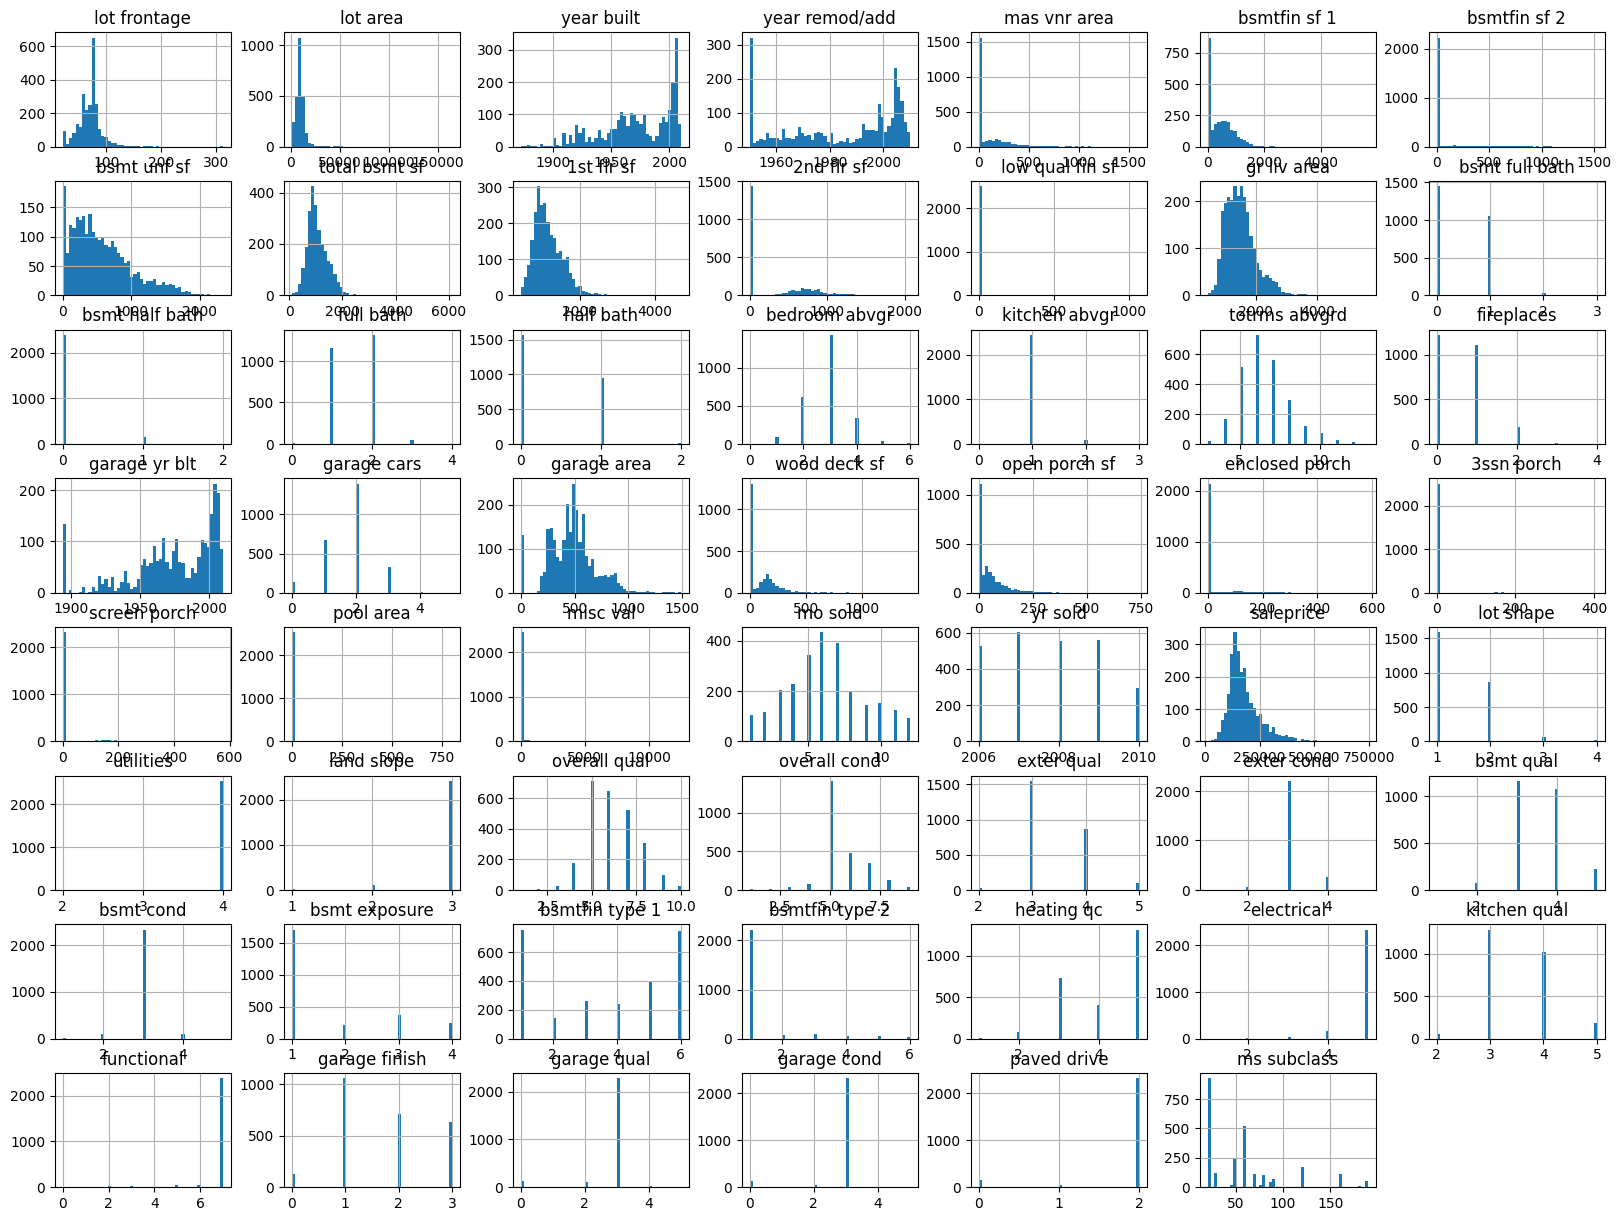

In [50]:
# histograms of data columns
housing_df_EDA.hist(bins = 50, figsize = (20, 15))
plt.title('Histogram of Data Columns')
plt.show()


It's interesting that I can see in the lot frontage histogram, I can see where I imputed many values close to the mean ~70. Similar observation for garage year built, I can see a tall bin in the earliest year. Interesting that we are seeing a similar bin pattern in year remodel/add. I wonder if a simular imputation was done to the dataset beforehand, or if that earliest year recorded was very popular for home remodeling.

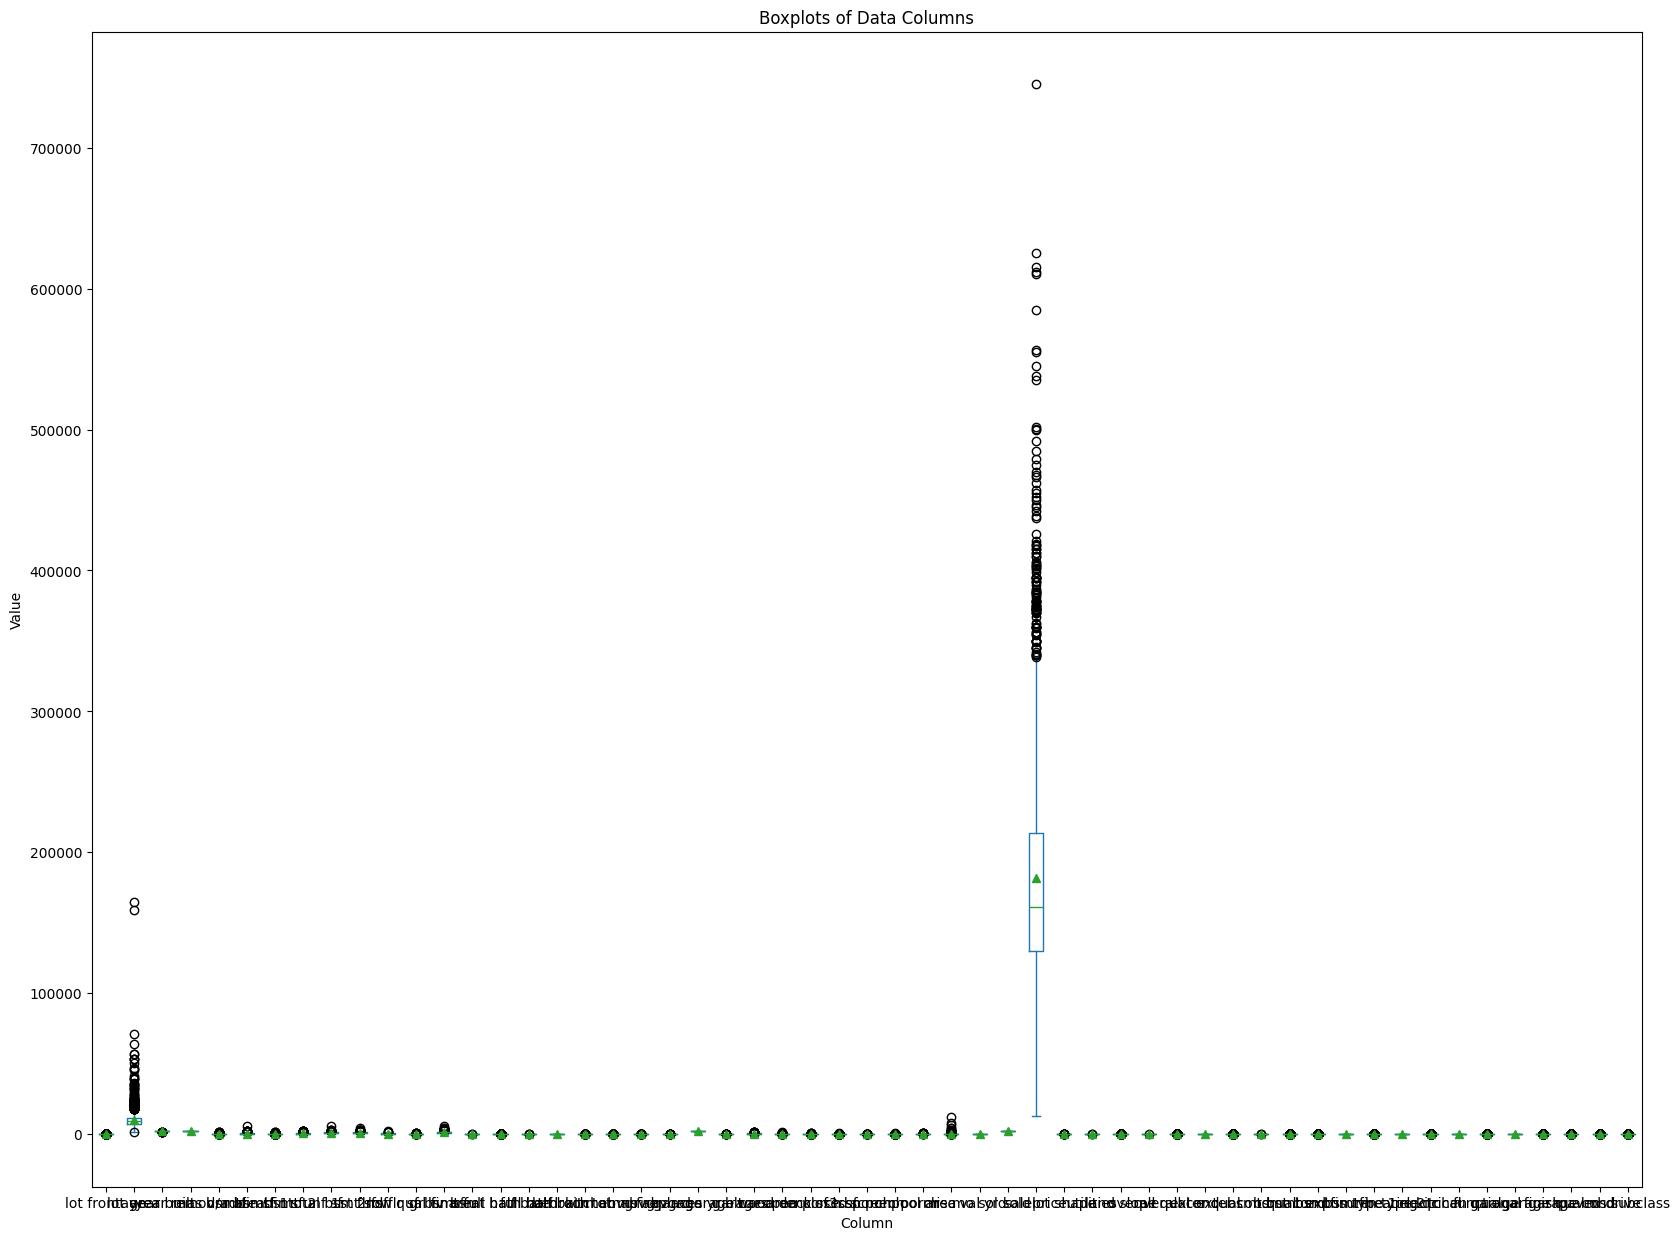

In [51]:
# boxplots
housing_df_EDA.plot(kind = 'box', showmeans = True, figsize = (20, 15))
plt.title('Boxplots of Data Columns')
plt.xlabel('Column')
plt.ylabel('Value')
plt.show()

With this base boxplot, we can see some issues immediately. We have a few variables where the value scales are much greater in magnitude compared the majority of the other variables. Let's make some prettier box blots to see if we can get a better look at the variables causing the massive scale difference.

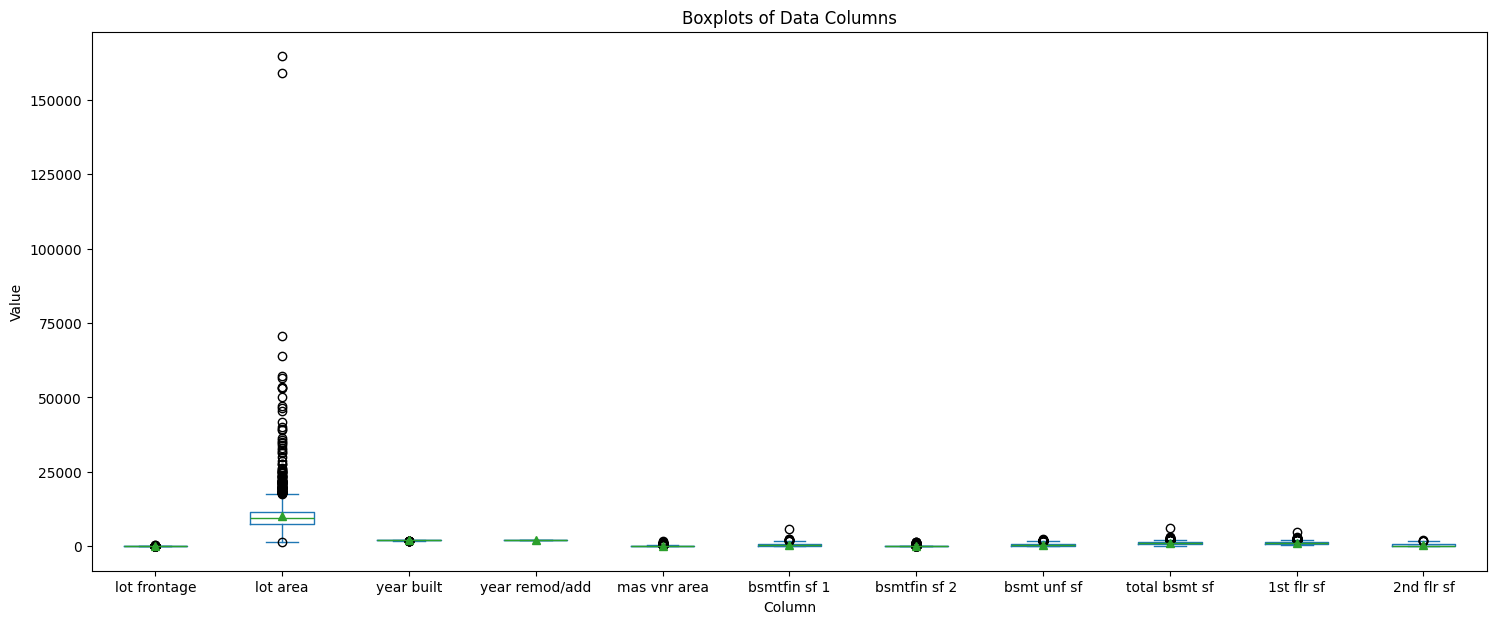

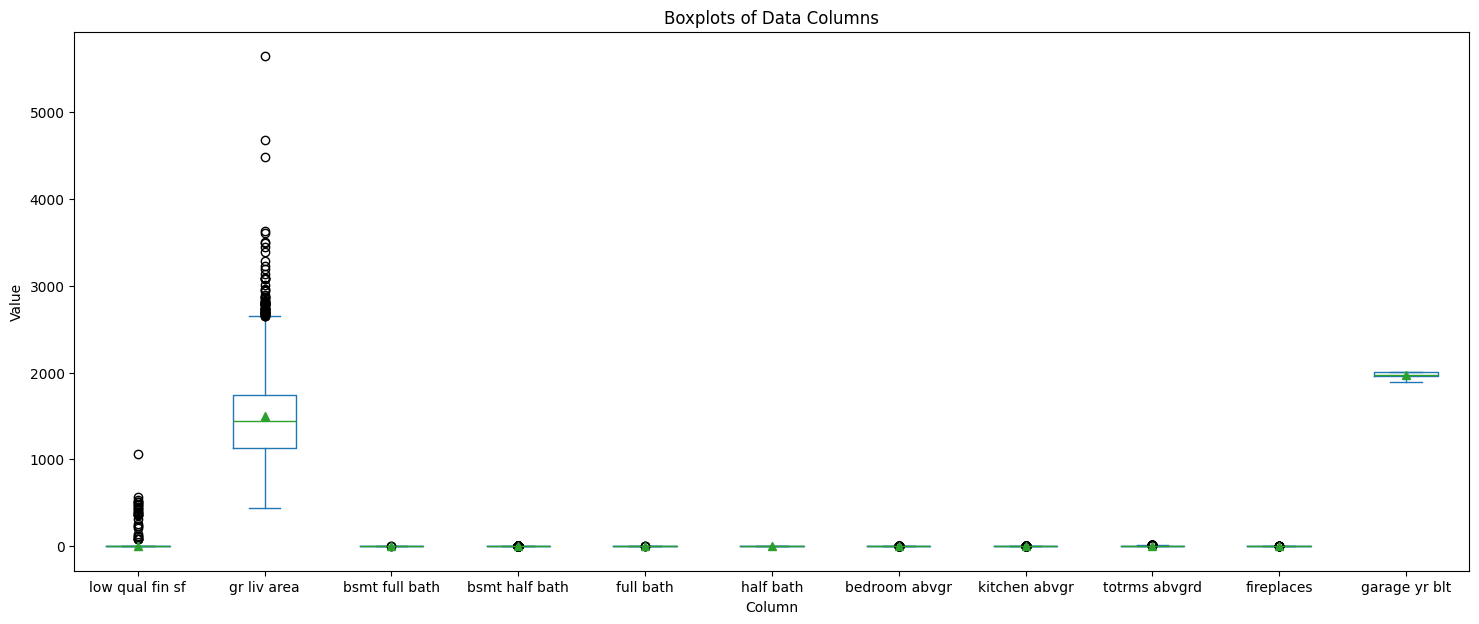

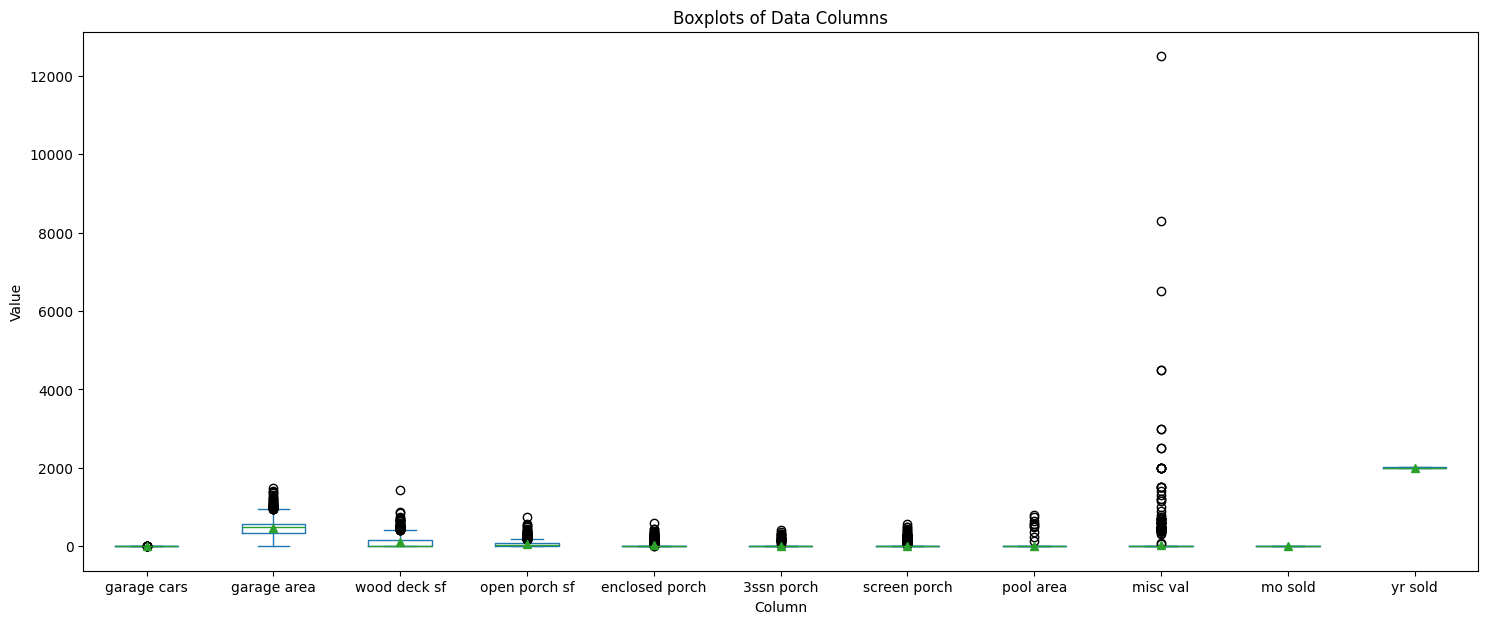

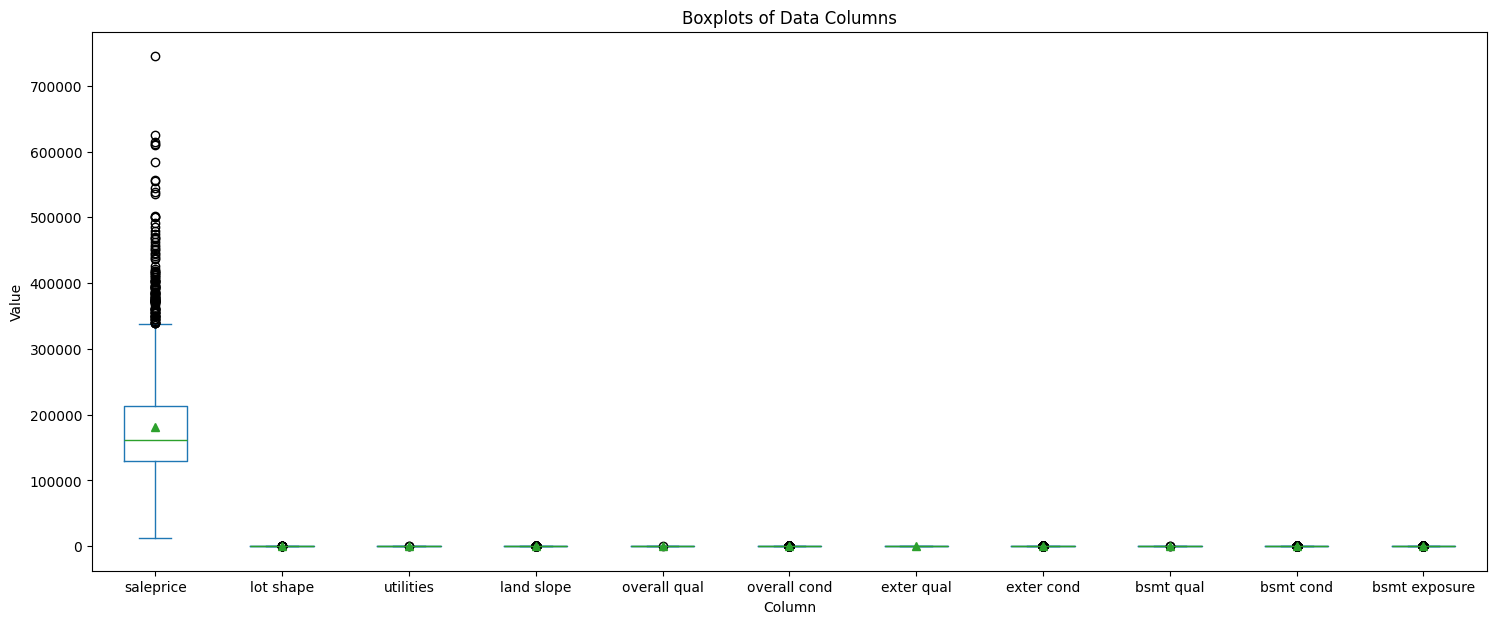

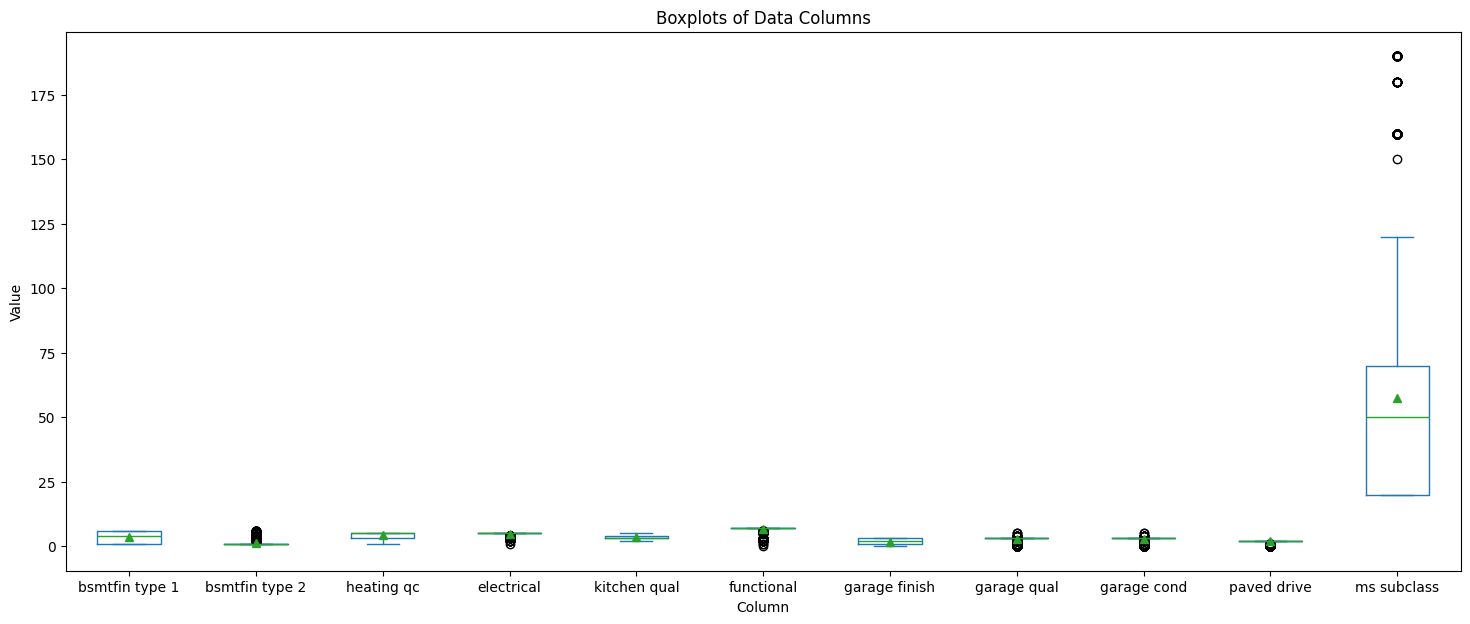

In [52]:
# call housing df of numerical columns
housing_num = housing_df_EDA.select_dtypes(include = ['int64', 'float64'])

# make boxplots of every 11 columns
for i in range(0, len(housing_num.columns), 11):
  housing_num.iloc[:, i:i+11].plot(kind = 'box', showmeans = True, figsize = (18, 7))
  plt.title('Boxplots of Data Columns')
  plt.xlabel('Column')
  plt.ylabel('Value')
  plt.show()


Here we see that data columns lot area, sales price, misc value, and gr liv area have ranges that are orders of magnitude larger than the majority of the other features. This means that we may have to go in and scale the data to have all of our features. Feature scaling may or may not impact the performance of the model, so for a first pass at the modeling I will leave the data points as they are.

### Feature Correlations

Next, let's look at the linear correlation between the features of the dataset. We want to ensure that our features are independent of one another for the linear regression model. If there is strong correlation between two variables, it can make it difficult for the model to accurately assess the impact of the individual features on the output.

A correlation matrix of all of the data columns will help us to visualize the relationships between all possible pairings.

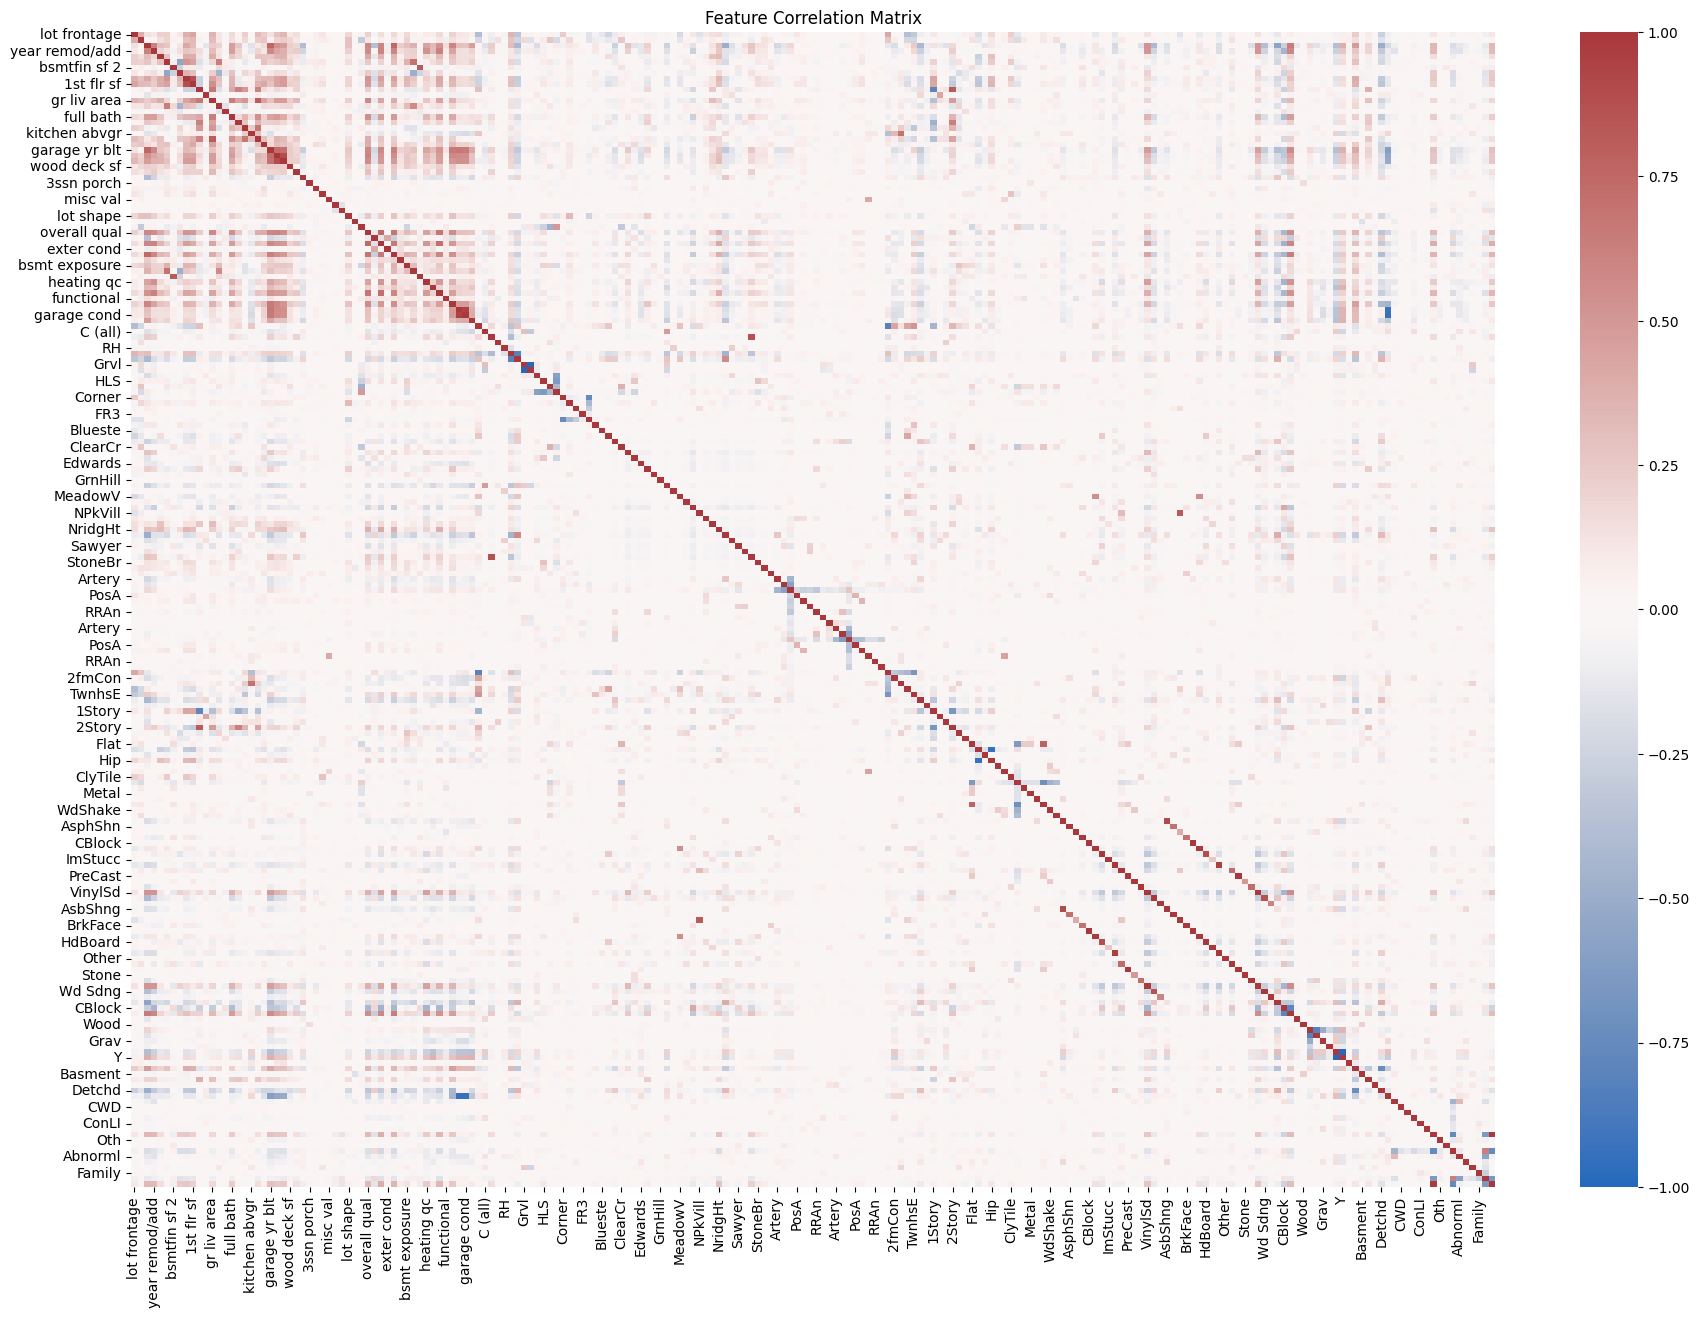

In [53]:
# feature linear correlation matrix
feat_corr_matrix = housing_df_EDA_feat.corr()

# sns matrix figure
fig, ax = plt.subplots(figsize=(22, 15))
feat_correlation_fig = sns.heatmap(feat_corr_matrix, cmap = sns.color_palette("vlag", as_cmap=True), annot = False, ax = ax)
feat_correlation_fig.set_title('Feature Correlation Matrix')
plt.show()


In this correlation matrix, we are looking for deep blue or deep red to indicate great linear correlation between two variables. Let's take a look at these specific features.

In [54]:
# absolute values of correlations
feat_corr_matrix_a = abs(feat_corr_matrix)

# df showing feature pairs with high correlation > 0.75
housing_df_corr = feat_corr_matrix_a[((feat_corr_matrix_a) > 0.75) & ((feat_corr_matrix_a) != 1)]
housing_df_corr = housing_df_corr.stack().reset_index()
housing_df_corr.columns = ['feature_1', 'feature_2', 'correlation']

housing_df_corr.sort_values(by = 'correlation', ascending = False)

,feature_1,feature_2,correlation
48,N,Y,1.000000
49,Y,N,1.000000
56,Partial,New,0.984342
53,New,Partial,0.984342
39,CmentBd,CemntBd,0.981157
32,CemntBd,CmentBd,0.981157
42,VinylSd,VinylSd,0.980049
35,VinylSd,VinylSd,0.980049
41,MetalSd,MetalSd,0.968620
34,MetalSd,MetalSd,0.968620


We will pin this dataframe for later as a reference for which features we may axe later on.

###Feature : Output Correlations

For linear regression models, it is important to have features that are linearly correlated to the output. Let's take a look at the correlation between the sales price and all of the individual features.

In [55]:
# correlation matrix of saleprice to all other data columns
feat_corr_matrix_out = abs(housing_df_EDA.corr()['saleprice'])
feat_corr_matrix_out = feat_corr_matrix_out.sort_values(ascending = False).drop('saleprice')
feat_corr_matrix_out.head(25)

,saleprice
overall qual,0.802483
gr liv area,0.710446
exter qual,0.698215
bsmt qual,0.678915
kitchen qual,0.677072
garage cars,0.650229
garage area,0.633571
1st flr sf,0.633287
total bsmt sf,0.631714
year built,0.558683


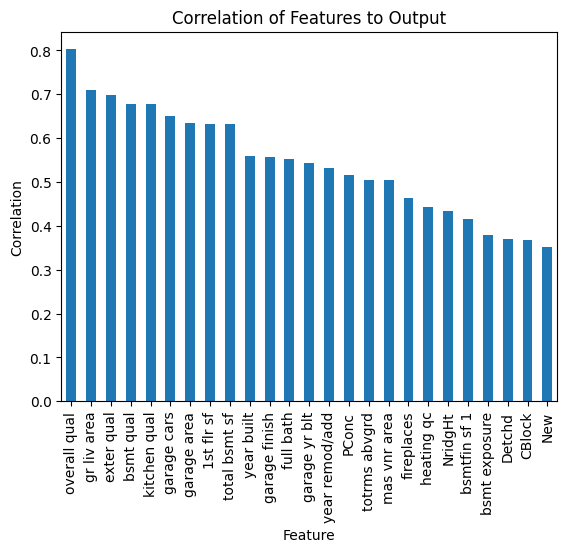

In [56]:
# plot bar chart of correlations to output
out_corr_chart = feat_corr_matrix_out.head(25).plot(kind = 'bar')
out_corr_chart.set_title('Correlation of Features to Output')
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.show()

Looks like we have about 9 features with really high linear correlation to the target. Getting into the 23rd feature and beyond, we are starting to see mild linear correlation. We will make sure to retain these features in the model if possible.

## Processing


In [57]:
housing_x = housing_df_EDA_feat.copy()
housing_y = housing_df_EDA_out.copy()

###First Pass of Linear Regression Fitting

It's now time to try our hand at fitting a model to predict home sales price using linear regression. I know this first pass may be a bit ugly, but we will get our baseline to work up from.

In [84]:
# Perform CV
def cv_rmse(X, y):
  """Given dataframe of features and data frame of output, fit linear regression model and return CV RMSE"""
  n = 500
  results = np.zeros(n)
  for idx in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[idx] = np.sqrt(mean_squared_error(y_test,y_pred))
  print(f'CV RMSE: {results.mean().round(2)}')
  print(f'CV RMSPE: {((y.mean() - results.mean()) / y.mean())}')
  print(f"Number of Predictors: {len(X.columns)}")

In [85]:
cv_rmse(housing_df_EDA_feat, housing_df_EDA_out)

CV RMSE: 28954.87
CV RMSPE: 0.8404772002423821
Number of Predictors: 210


So our baseline CV RSME ~29,000

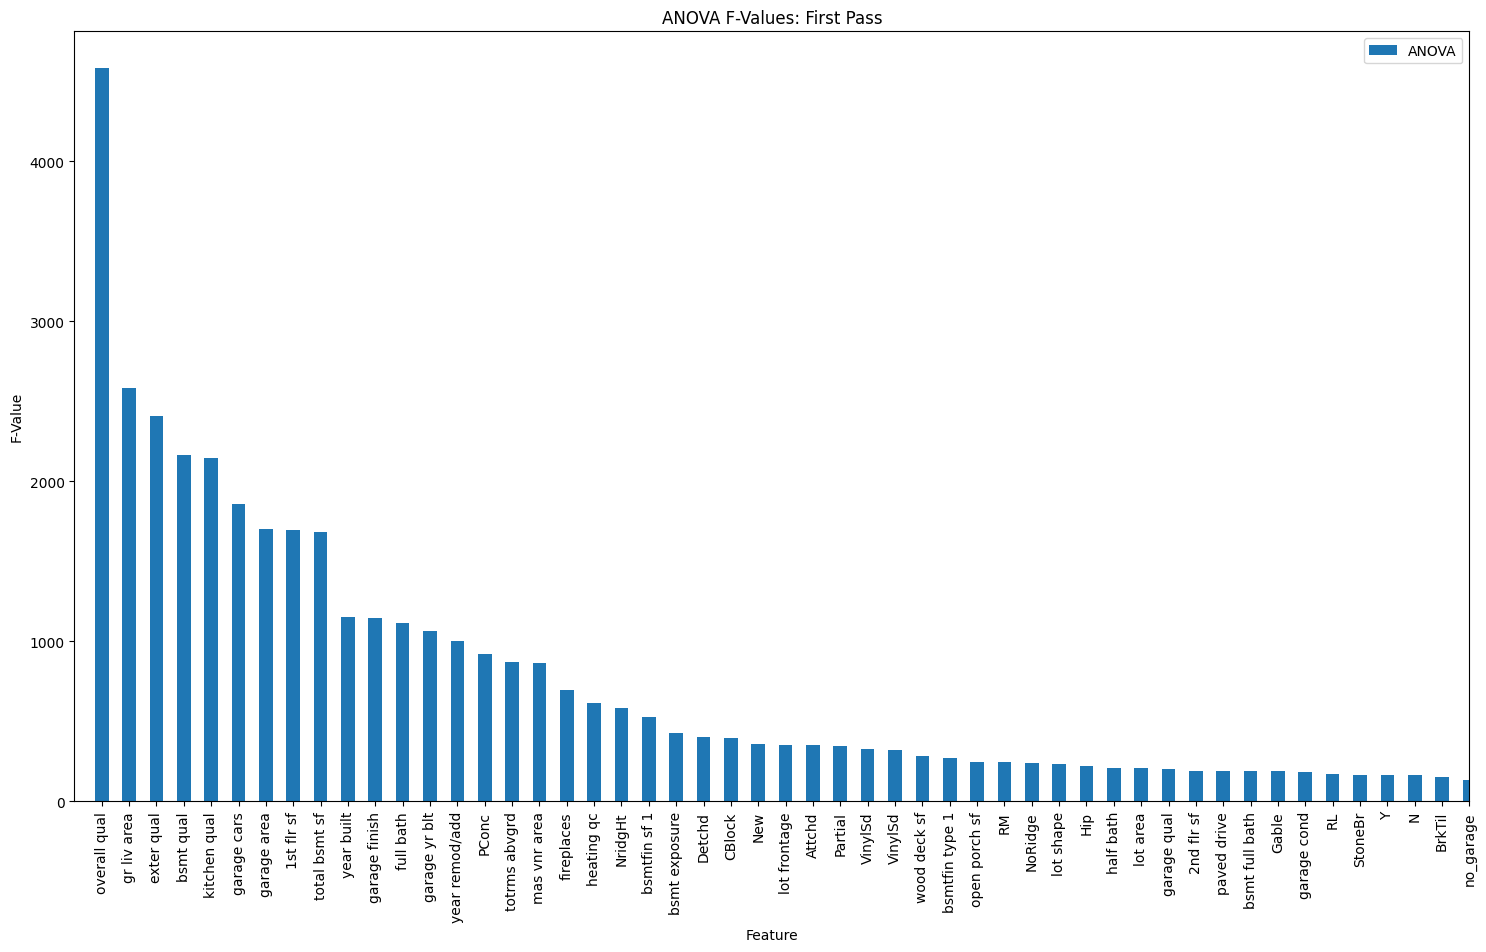

In [60]:
fvalue_selector = SelectKBest(f_regression, k='all')  #select features best ANOVA F-Values
fvalue_selector.fit_transform(housing_x, housing_y)

# Plot results
results = pd.DataFrame({'ANOVA': fvalue_selector.scores_}, index = housing_x.columns)
results.sort_values(by = 'ANOVA', ascending = False).plot(kind = 'bar', figsize = (18, 10))
plt.title('ANOVA F-Values: First Pass')
plt.xlabel('Feature')
plt.xlim(-1, 50)
plt.ylabel('F-Value')
plt.show()

In [61]:
# Just keep the results with F-values greater than 50
anova = results.sort_values(by = 'ANOVA', ascending = False)
keep = anova['ANOVA'][anova['ANOVA'] > 50]
keep

,ANOVA
overall qual,4583.546741
gr liv area,2582.442192
exter qual,2410.424646
bsmt qual,2166.643803
kitchen qual,2144.954740
...,...
Abnorml,56.336565
enclosed porch,55.920630
bsmt unf sf,54.990435
CulDSac,53.310420


###Second Pass

let's try scaling our data set to get rid of the large range of values going through the modeler. I am going to use robust scaling since we have outliers in the dataset.

In [62]:
# robust scaling for continuous columns in housing_x
cont = housing_x.select_dtypes(include = ['int64', 'float64'])
cont

,lot frontage,lot area,year built,year remod/add,mas vnr area,bsmtfin sf 1,bsmtfin sf 2,bsmt unf sf,total bsmt sf,1st flr sf,...,bsmtfin type 2,heating qc,electrical,kitchen qual,functional,garage finish,garage qual,garage cond,paved drive,ms subclass
0,62.0,14299,1964,1964,0.0,513.0,144.0,348.0,1005.0,1005,...,2,3,5,3,7,1,3,3,0,20
2,50.0,9000,1937,1950,0.0,0.0,0.0,780.0,780.0,780,...,1,3,5,4,7,1,3,3,1,50
3,68.0,7379,2000,2000,0.0,484.0,0.0,491.0,975.0,975,...,1,5,5,4,7,2,3,3,2,60
4,60.0,7200,1936,2007,0.0,350.0,210.0,0.0,560.0,575,...,4,5,5,4,7,2,3,3,2,70
5,70.0,8521,1967,1967,0.0,842.0,0.0,70.0,912.0,912,...,1,3,5,3,7,1,3,3,2,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,52.0,6240,1934,1950,0.0,0.0,0.0,816.0,816.0,816,...,1,3,5,3,7,1,3,3,2,50
2633,74.0,10778,1990,1991,0.0,460.0,286.0,308.0,1054.0,1061,...,5,4,5,4,7,1,3,3,2,80
2634,61.0,3782,1981,1981,0.0,960.0,0.0,266.0,1226.0,1226,...,1,3,5,4,7,3,3,3,2,120
2635,78.0,10140,1974,1974,174.0,0.0,0.0,1064.0,1064.0,1350,...,1,3,5,3,7,2,3,3,2,20


In [63]:
scaler = preprocessing.RobustScaler()
robust_scaled_df = scaler.fit_transform(cont)
robust_scaled_df_cont = pd.DataFrame(robust_scaled_df, columns= cont.columns)
robust_scaled_df_cont


,lot frontage,lot area,year built,year remod/add,mas vnr area,bsmtfin sf 1,bsmtfin sf 2,bsmt unf sf,total bsmt sf,1st flr sf,...,bsmtfin type 2,heating qc,electrical,kitchen qual,functional,garage finish,garage qual,garage cond,paved drive,ms subclass
0,-0.611111,1.186312,-0.217391,-0.763158,0.000000,0.174324,144.0,-0.231173,0.009137,-0.152618,...,1.0,-1.0,0.0,0.0,0.0,-0.5,0.0,0.0,-2.0,-0.6
1,-1.277778,-0.113578,-0.804348,-1.131579,0.000000,-0.518919,0.0,0.525394,-0.447716,-0.601496,...,0.0,-1.0,0.0,1.0,0.0,-0.5,0.0,0.0,-1.0,0.0
2,-0.277778,-0.511223,0.565217,0.184211,0.000000,0.135135,0.0,0.019264,-0.051777,-0.212469,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.2
3,-0.722222,-0.555133,-0.826087,0.368421,0.000000,-0.045946,210.0,-0.840630,-0.894416,-1.010474,...,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.4
4,-0.166667,-0.231081,-0.152174,-0.684211,0.000000,0.618919,0.0,-0.718039,-0.179695,-0.338155,...,0.0,-1.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,-0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2531,-1.166667,-0.790629,-0.869565,-1.131579,0.000000,-0.518919,0.0,0.588441,-0.374619,-0.529676,...,0.0,-1.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0
2532,0.055556,0.322581,0.347826,-0.052632,0.000000,0.102703,286.0,-0.301226,0.108629,-0.040898,...,4.0,-0.5,0.0,1.0,0.0,-0.5,0.0,0.0,0.0,0.6
2533,-0.666667,-1.393597,0.152174,-0.315789,0.000000,0.778378,0.0,-0.374781,0.457868,0.288279,...,0.0,-1.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,1.4
2534,0.277778,0.166074,0.000000,-0.500000,1.034175,-0.518919,0.0,1.022767,0.128934,0.535661,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.6


In [86]:
cv_rmse(robust_scaled_df_cont, housing_y)

CV RMSE: 31317.05
CV RMSPE: 0.8274631218830989
Number of Predictors: 54


## Data Visualization/Communication of Results


Current Best:


CV RMSE: 29101.0


Number of Predictors: 210